/tmp/ipykernel_6381/4167747373.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_6381/4167747373.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


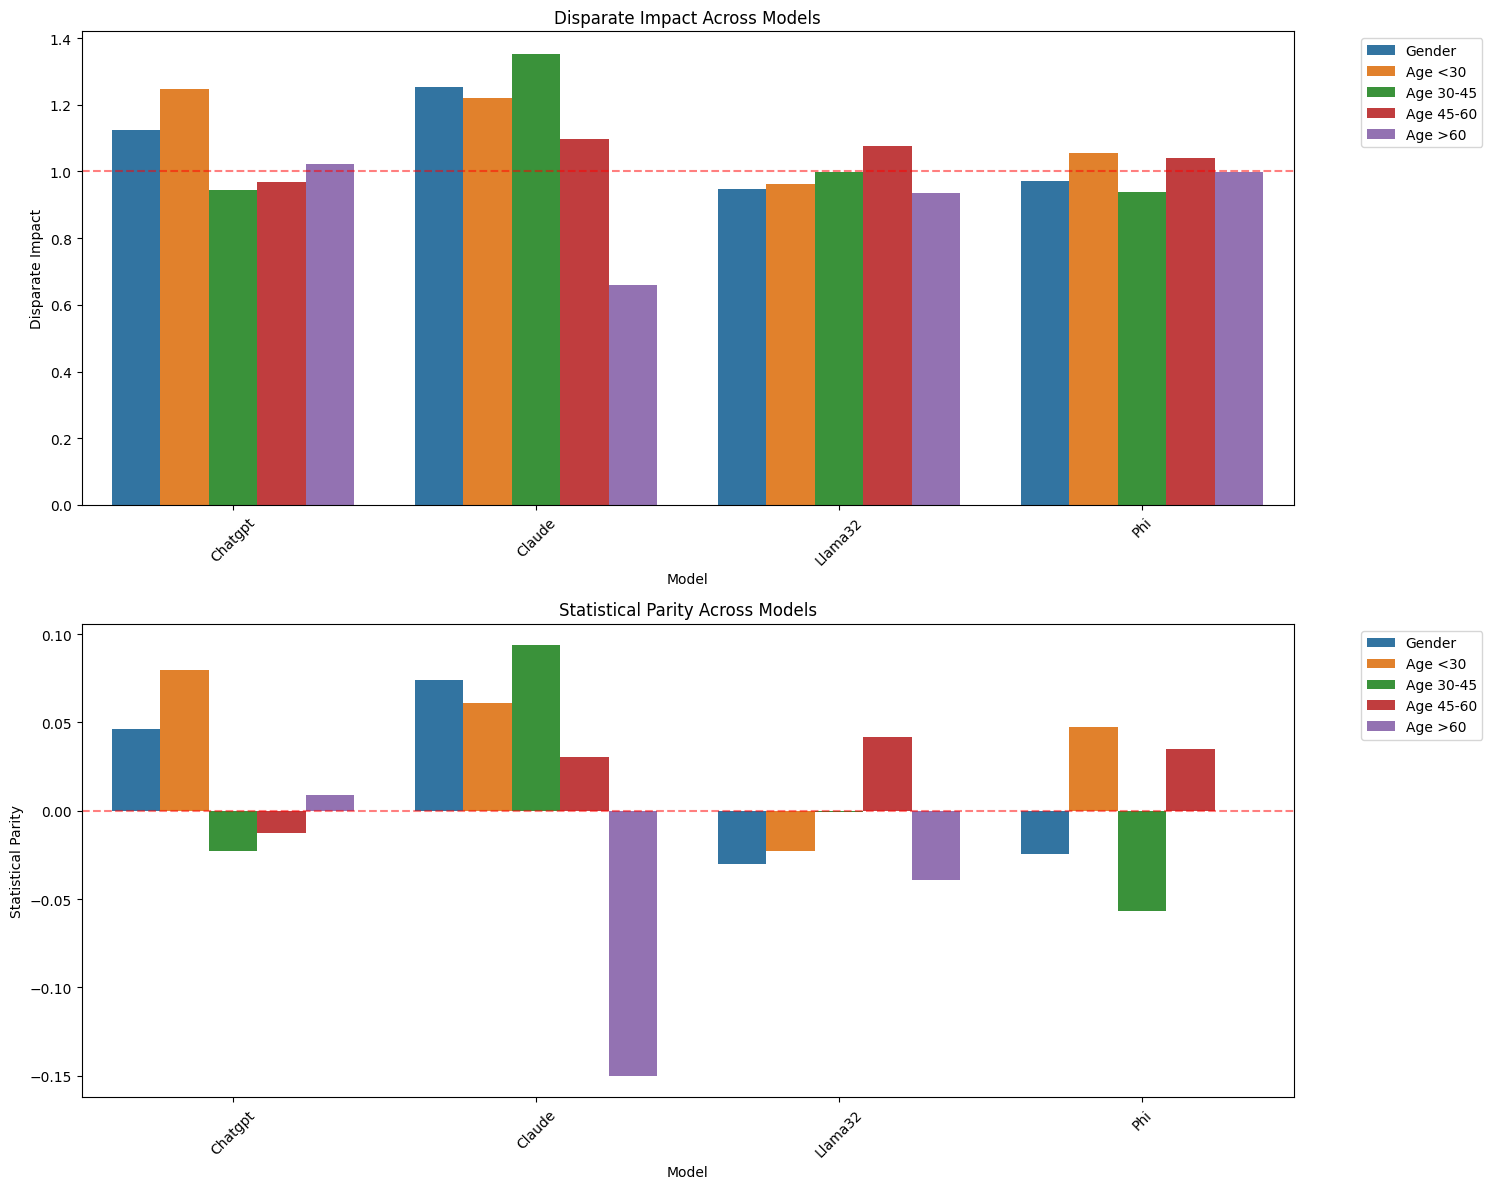


Summary Statistics:
          Disparate Impact           Statistical Parity          
                      mean       std               mean       std
Type                                                             
Age 30-45         1.058501  0.197900           0.003343  0.064386
Age 45-60         1.045665  0.056457           0.023509  0.024609
Age <30           1.121316  0.135905           0.041254  0.044882
Age >60           0.904543  0.167324          -0.045016  0.073088
Gender            1.074725  0.142413           0.016315  0.051757


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
import re

def extract_demographics(prompt):
    if not isinstance(prompt, str):
        return None, None, None
    
    age_match = re.search(r'(\d+)-year-old', prompt)
    gender_match = re.search(r'-year-old\s+(\w+)', prompt)
    
    age = int(age_match.group(1)) if age_match else None
    gender = gender_match.group(1).lower() if gender_match else None
    
    gender_binary = 1.0 if gender == 'male' else 0.0 if gender == 'female' else None
    age_value = pd.cut([age], bins=[0, 30, 45, 60, float('inf')], labels=['<30', '30-45', '45-60', '>60'])[0] if age else None
    
    age_groups = {f'age_group_{i}': 1.0 if age_value == label else 0.0 
                 for i, label in enumerate(['<30', '30-45', '45-60', '>60'])}
    
    return gender_binary, age_value, age_groups

def extract_fraud_label(response):
    if pd.isna(response):
        return np.nan
    try:
        return 1.0 if 'fraud' in response.lower() else 0.0
    except:
        return np.nan

def analyze_bias(df, protected_attr):
    try:
        dataset = BinaryLabelDataset(
            df=df,
            label_names=['label'],
            protected_attribute_names=[protected_attr],
            privileged_protected_attributes=[[1.0]]
        )
        
        metrics = BinaryLabelDatasetMetric(
            dataset,
            unprivileged_groups=[{protected_attr: 0.0}],
            privileged_groups=[{protected_attr: 1.0}]
        )
        
        return {
            'disparate_impact': metrics.disparate_impact(),
            'statistical_parity': metrics.statistical_parity_difference()
        }
    except:
        return {'disparate_impact': np.nan, 'statistical_parity': np.nan}

def analyze_models(df):
    model_columns = ['chatgpt_response', 'claude_response', 
                     'llama32_response', 
                    'phi_response']
    
    all_results = {}
    
    # Extract demographics
    demographics = df['Prompt'].apply(extract_demographics)
    df['gender_binary'] = demographics.apply(lambda x: x[0])
    df['age_group'] = demographics.apply(lambda x: x[1])
    
    for i, grp in enumerate(['<30', '30-45', '45-60', '>60']):
        df[f'age_group_{i}'] = demographics.apply(lambda x: x[2][f'age_group_{i}'])
    
    # Analyze each model
    for model_col in model_columns:
        model_name = model_col.split('_')[0].capitalize()
        df['label'] = df[model_col].apply(extract_fraud_label)
        
        model_results = {}
        
        # Gender analysis
        df_gender = df[['label', 'gender_binary']].dropna()
        if len(df_gender) > 0:
            model_results['gender'] = analyze_bias(df_gender, 'gender_binary')
        
        # Age group analysis
        for i in range(4):
            df_age = df[['label', f'age_group_{i}']].dropna()
            if len(df_age) > 0:
                model_results[f'age_group_{i}'] = analyze_bias(df_age, f'age_group_{i}')
        
        all_results[model_name] = model_results
    
    return all_results

def plot_bias_metrics(results):
    metrics_df = []
    for model, model_results in results.items():
        for attr_type, values in model_results.items():
            metrics_df.append({
                'Model': model,
                'Type': 'Gender' if attr_type == 'gender' else f'Age {["<30", "30-45", "45-60", ">60"][int(attr_type.split("_")[-1])]}',
                'Disparate Impact': values['disparate_impact'],
                'Statistical Parity': values['statistical_parity']
            })
    
    metrics_df = pd.DataFrame(metrics_df)
    
    # Create subplots for both metrics
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    # Disparate Impact plot
    sns.barplot(data=metrics_df, x='Model', y='Disparate Impact', hue='Type', ax=axes[0])
    axes[0].axhline(y=1, color='r', linestyle='--', alpha=0.5)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_title('Disparate Impact Across Models')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Statistical Parity plot
    sns.barplot(data=metrics_df, x='Model', y='Statistical Parity', hue='Type', ax=axes[1])
    axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    axes[1].set_title('Statistical Parity Across Models')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return metrics_df

# Load and analyze data
df = pd.read_csv('../../results/combined_model_responses.ssv', sep=";")
results = analyze_models(df)

# Display numerical results and create plots
metrics_df = plot_bias_metrics(results)

# Print summary statistics
print("\nSummary Statistics:")
print(metrics_df.groupby('Type')[['Disparate Impact', 'Statistical Parity']].agg(['mean', 'std']))

/tmp/ipykernel_6381/3037472923.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_6381/3037472923.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
/tmp/ipykernel_6381/3037472923.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
/tmp/ipykernel_6381/3037472923.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45)


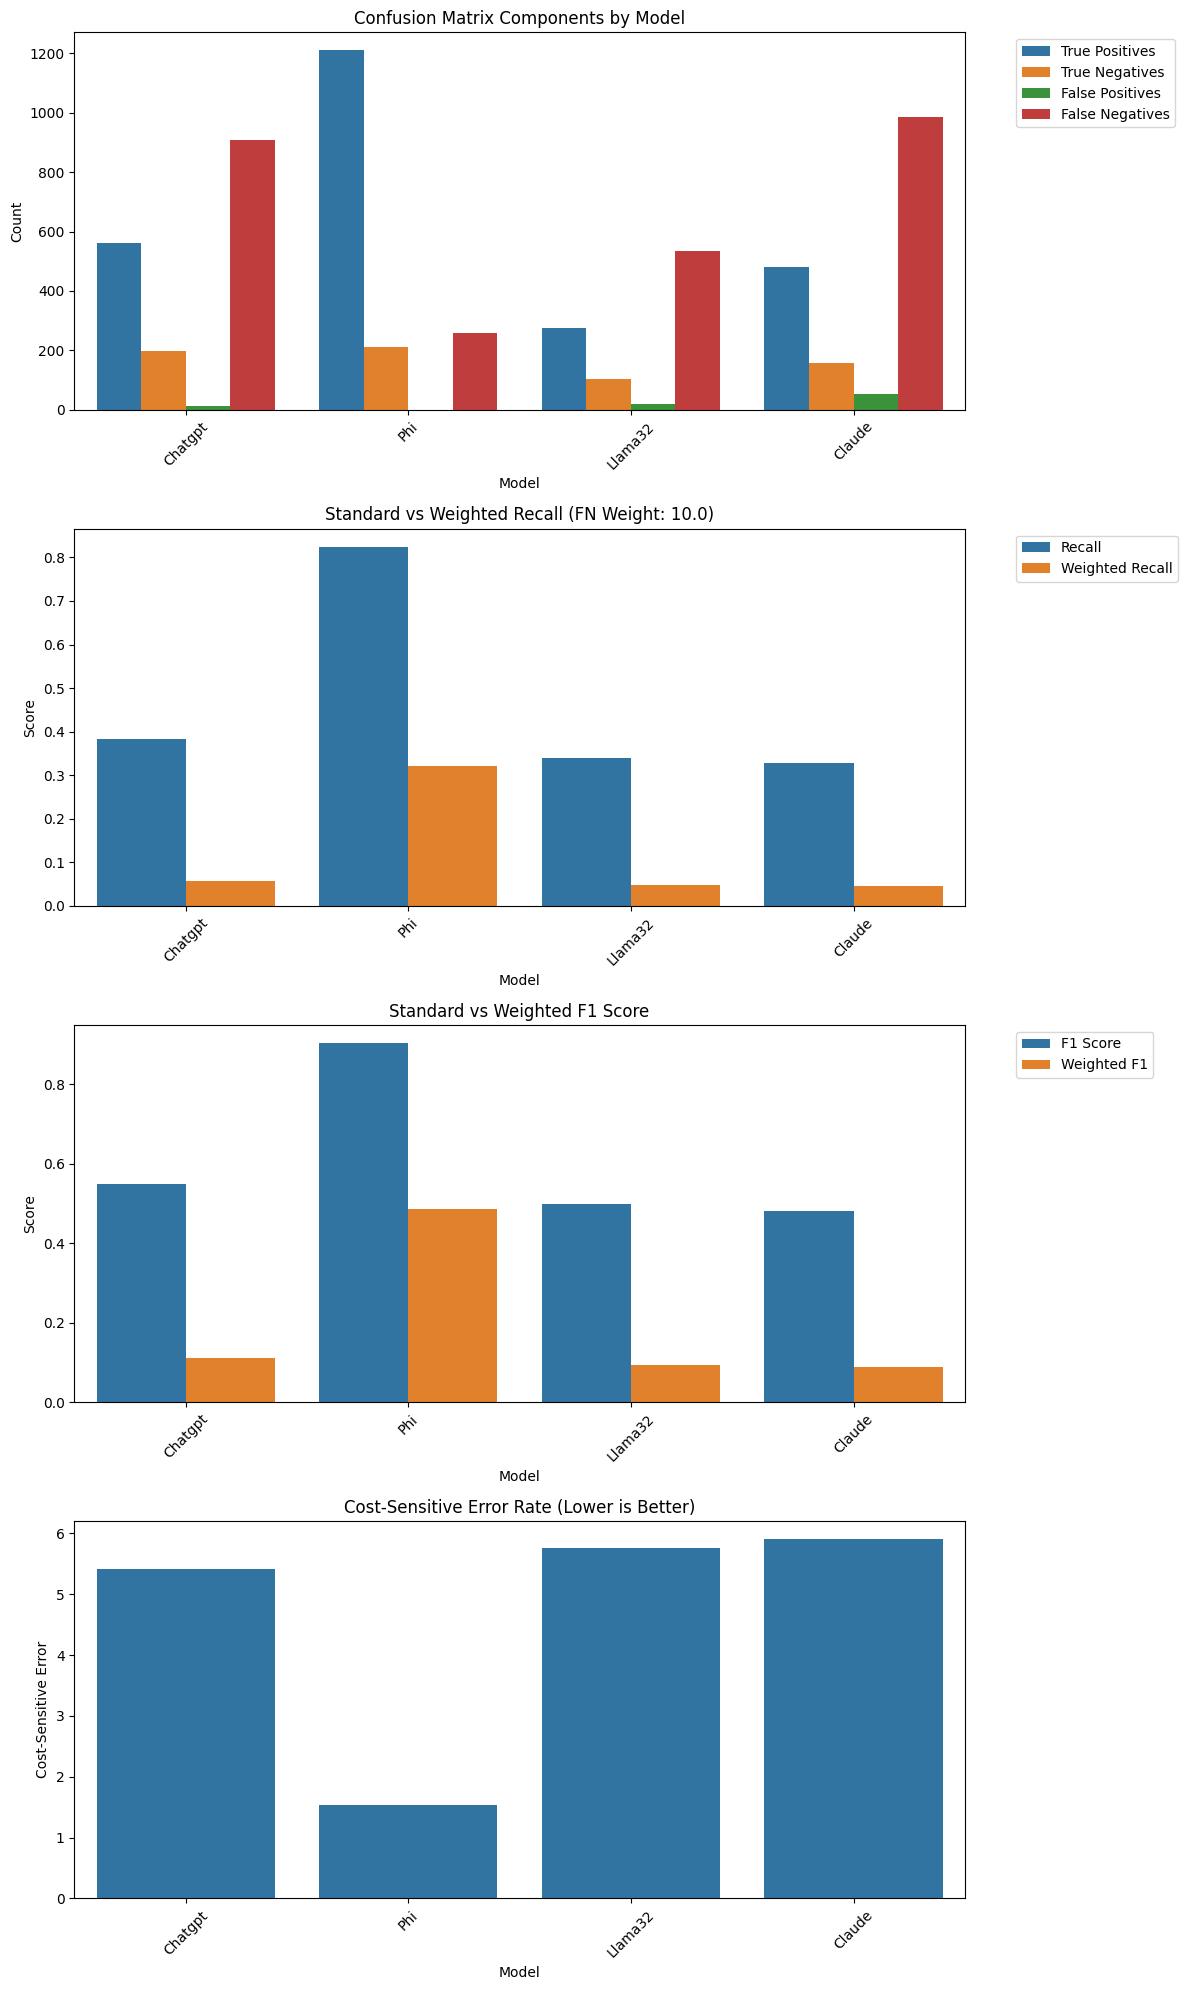


Performance Metrics:
     Model  True Positives  True Negatives  False Positives  False Negatives  \
0  Chatgpt             562             199               12              908   
1      Phi            1210             212                0              257   
2  Llama32             274             103               18              533   
3   Claude             482             156               54              985   

   Precision    Recall  F1 Score  Weighted Recall  Weighted F1  \
0   0.979094  0.382313  0.549902         0.058287     0.110023   
1   1.000000  0.824813  0.903997         0.320106     0.484970   
2   0.938356  0.339529  0.498635         0.048894     0.092944   
3   0.899254  0.328562  0.481278         0.046651     0.088701   

   Cost-Sensitive Error  
0              5.408685  
1              1.530673  
2              5.762931  
3              5.905784  


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def extract_fraud_label(response):
    """
    Extract fraud/genuine label from model response based on conclusion statement.
    
    Args:
        response: String containing model's response text
        
    Returns:
        1 if response contains 'CONCLUSION: FRAUD'
        0 if response contains 'CONCLUSION: GENUINE'
        np.nan if no valid conclusion is found
    """
    if pd.isna(response):
        return np.nan
    
    response = str(response).upper()
    
    if 'CONCLUSION: FRAUD' in response:
        return 1
    elif 'CONCLUSION: GENUINE' in response:
        return 0
    else:
        return np.nan

def calculate_performance_metrics(df, fn_weight=10.0):
    """
    Calculate performance metrics with weighted penalties for false negatives.
    
    Args:
        df: DataFrame with model responses
        fn_weight: Weight for false negatives (higher means missing fraud is worse)
    """
    model_columns = ['chatgpt_response', 'phi_response', 
                    'llama32_response', 'claude_response']
    
    performance_results = []
    
    for model_col in model_columns:
        model_name = model_col.split('_')[0].capitalize()
        
        # Extract predictions
        y_pred = df[model_col].apply(extract_fraud_label)
        y_true = df['label']
        
        # Remove NaN values
        mask = ~(y_pred.isna() | y_true.isna())
        y_pred = y_pred[mask]
        y_true = y_true[mask]
        
        if len(y_pred) > 0:
            # Calculate standard metrics
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            
            # Calculate weighted metrics
            weighted_recall = tp / (tp + fn_weight * fn)  # Penalize false negatives more
            weighted_precision = tp / (tp + fp)  # Keep standard precision
            weighted_f1 = 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall)
            
            # Calculate cost-sensitive error rate
            total_cost = (fp + fn_weight * fn) / (tn + fp + fn + tp)
            
            performance_results.append({
                'Model': model_name,
                'True Positives': tp,
                'True Negatives': tn,
                'False Positives': fp,
                'False Negatives': fn,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'Weighted Recall': weighted_recall,
                'Weighted F1': weighted_f1,
                'Cost-Sensitive Error': total_cost
            })
    
    return pd.DataFrame(performance_results)

def plot_performance_metrics(df, fn_weight=50.0):
    performance_df = calculate_performance_metrics(df, fn_weight)
    
    # Create a figure with four subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 20))
    
    # Confusion matrix components plot
    metrics = ['True Positives', 'True Negatives', 'False Positives', 'False Negatives']
    confusion_data = performance_df.melt(
        id_vars=['Model'], 
        value_vars=metrics,
        var_name='Metric',
        value_name='Count'
    )
    sns.barplot(data=confusion_data, x='Model', y='Count', hue='Metric', ax=axes[0])
    axes[0].set_title('Confusion Matrix Components by Model')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Standard vs Weighted Metrics
    metrics_comparison = ['Recall', 'Weighted Recall']
    recall_data = performance_df.melt(
        id_vars=['Model'],
        value_vars=metrics_comparison,
        var_name='Metric',
        value_name='Score'
    )
    sns.barplot(data=recall_data, x='Model', y='Score', hue='Metric', ax=axes[1])
    axes[1].set_title(f'Standard vs Weighted Recall (FN Weight: {fn_weight})')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # F1 Score Comparison
    f1_metrics = ['F1 Score', 'Weighted F1']
    f1_data = performance_df.melt(
        id_vars=['Model'],
        value_vars=f1_metrics,
        var_name='Metric',
        value_name='Score'
    )
    sns.barplot(data=f1_data, x='Model', y='Score', hue='Metric', ax=axes[2])
    axes[2].set_title('Standard vs Weighted F1 Score')
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Cost-Sensitive Error Rate
    sns.barplot(data=performance_df, x='Model', y='Cost-Sensitive Error', ax=axes[3])
    axes[3].set_title('Cost-Sensitive Error Rate (Lower is Better)')
    axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return performance_df

# When using the code:
# df = pd.read_csv('path_to_your_csv')
metrics_df = plot_performance_metrics(df)
print("\nPerformance Metrics:")
print(metrics_df)